# pyiron: First steps

This section gives a brief introduction about fundamental concepts of pyiron and how they can be used to setup, run and analyze atomic simulations. 

As a first step we import pyiron.

In [1]:
from pyiron.project import Project

The Project object is central in pyiron. It allows to name the project as well as to derive all other objects such as structures, jobs etc. without having to import them. Thus by code completion *Tab* the respective commands can be found easily.

Further, we import numpy for data analysis and matplotlib for visualization.

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

We now create a pyiron Project named 'first_steps'.

In [ ]:
pr = Project(path='first_steps')

This command creates the project directory named 'first_steps'.

## Perform a LAMMPS MD simulation

Having created an instance of the pyiron Project we now perform a LAMMPS MD (http://lammps.sandia.gov/) simulation. 

For this basic simulation example we construct an fcc Al crystal in a cubic supercell (`*cubic=True*`).

In [ ]:
cell = pr.create_ase_bulk('Al', cubic=True)
supercell_3x3x3 = cell.repeat([3, 3, 3])
supercell_3x3x3.plot3d()

Where `create_ase_bulk` uses the [ASE bulk module](https://wiki.fysik.dtu.dk/ase/ase/build/build.html). The structure can be modified - here we extend the original cell to a 3x3x3 supercell (`repeat([3, 3, 3]`). Finally, we plot the structure using [NGlview](http://nglviewer.org/nglview/latest/api.html).

The project object allows to create various simulation jobs. Here we create a LAMMPS job. We specify a Molecular Dynamics simulation at T=800 K. 

In [3]:
job = pr.create_job(job_type=pr.job_type.Lammps, job_name='Al_T800K')
job.structure = supercell_3x3x3
job.calc_md(temperature=800, n_ionic_steps=10000)

['Al_Mg_Mendelev_eam', 'Zope_Ti_Al_2003_eam', 'Al_H_Ni_Angelo_eam']

To see all available potentials which are compatible with the structure (for our example they must contain Al) and the job type (here LAMMPS) we call `job.list_potentials()`.

In [ ]:
job.list_potentials()

From the above let us select the first potential in the list.

In [4]:
pot = job.list_potentials()[0]
print ('selected potential: ', pot)
job.potential = pot

select potential  Al_Mg_Mendelev_eam


To run the LAMMPS simulation (locally) we now simply use

In [ ]:
job.run()

## Analyse the calculation

After the simulation has finished the information about the job can be accessed through the Project object.

In [6]:
job = pr['Al_T800K']
job

{'groups': ['input', 'output'], 'nodes': ['TYPE', 'server', 'VERSION', 'NAME']}

Printing the job object (note that in Jupyter we don't have to call a print statement if the variable/object is in the last line). The output lists the variables (nodes) and the directories (groups). To get a list of all variables stored in the generic output we type:

In [7]:
job['output/generic']

{'groups': [], 'nodes': ['steps', 'forces', 'pressures', 'energy_pot', 'energy_tot', 'cells', 'volume', 'time', 'unwrapped_positions', 'positions', 'temperatures']}

An animated 3d plot of the MD trajectories is created by:

In [8]:
job.animate_structure()

NGLWidget(count=101)

To analyze the temperature evolution we plot it as function of the MD step:

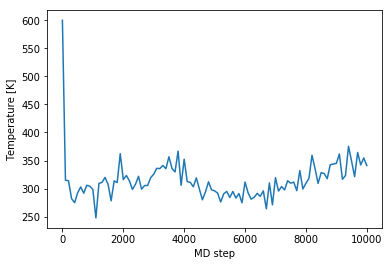

In [9]:
temperatures = job['output/generic/temperatures']
steps = job['output/generic/steps']
plt.plot(steps, temperatures)
plt.xlabel('MD step')
plt.ylabel('Temperature [K]');

In the same way we can plot the trajectories:

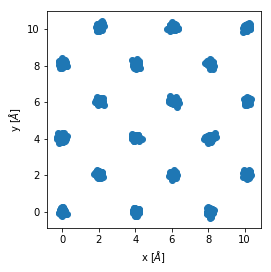

In [10]:
pos = job['output/generic/positions']
x, y, z = [pos[:, :, i] for i in range(3)]
sel = np.abs(z) < 0.1
fig, axs = plt.subplots(1,1)
axs.scatter(x[sel], y[sel])
axs.set_xlabel('x [$\AA$]')
axs.set_ylabel('y [$\AA$]')
axs.set_aspect('equal', 'box');

## Perform a series of jobs

To run the MD simulation for various temperatures we can simply loop over the desired temperature values

In [11]:
for temperature in np.arange(200, 1200, 200):
    job = pr.create_job(pr.job_type.Lammps, 'Al_T{}K'.format(int(temperature)))
    job.structure = supercell_3x3x3
    job.potential = pot     
    job.calc_md(temperature=temperature, pressure=0, n_ionic_steps=10000)
    job.run()

To inspect the list of jobs in our current project we type (note that the existing job from the previous excercise at 800K has been recognized and not run again):

In [12]:
pr

['Al_T400K', 'Al_T800K', 'Al_T600K', 'Al_T200K', 'Al_T1000K']

We can now iterate over the jobs and extract volume and mean temperature:

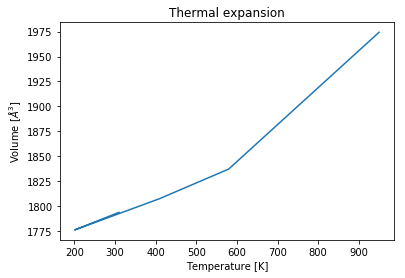

In [13]:
vol_lst, temp_lst = [], []
for job in pr.iter_jobs(convert_to_object=False):
    volumes = job['output/generic/volume']
    temperatures = job['output/generic/temperatures']
    temp_lst.append(np.mean(temperatures[:-20]))
    vol_lst.append(np.mean(volumes[:-20]))

Here, we work in a NPT ensamble and we can use the extraced information to plot the thermal expansion.

In [ ]:
plt.figure()
plt.plot(temp_lst, vol_lst)
plt.title('Thermal expansion')
plt.xlabel('Temperature [K]')
plt.ylabel('Volume [$\AA^3$]');

## Create a series of projects

We extend the previous example and compute the thermal expansion for all of the available Al potentials.

First, let us create a new pyiron project named 'Al_potentials' and use the information of the previously run job 'Al_T200K' of the 'first_steps' project to find all the compatible potentials.

In [ ]:
pr = Project('Al_potentials')
pot_lst = pr['../first_steps/Al_T200K'].load_object().list_potentials()[:3]

Note again that `list_potentials()` automatically only returns the potentials that are compatible with the structure and the job type.

We can now loop over the selected potentials and run the MD simulation for the desired temperature values for any of the potentials.

In [14]:
for pot in pot_lst:
    print (pot)
    pr_pot = pr.create_group(pot)
    for temperature in np.arange(200, 1200, 200):
        job = pr_pot.create_job(pr.job_type.Lammps, 'Al_T{}K'.format(int(temperature)))
        job.structure = supercell_3x3x3
        job.potential = pot                
        job.calc_md(temperature=temperature, pressure=0, n_ionic_steps=10000)
        job.run()

Al_Mg_Mendelev_eam
Zope_Ti_Al_2003_eam
Al_H_Ni_Angelo_eam


With the `pr.create_group()` command a new subproject (directory) is created named here by the label of the potential. 

For a particular potential the thermal expansion data can be obtained again by looping over the jobs performed for the potential (`p.iter_jobs()`). To obtain the thermal expansion curves for all the potentials used we can simply iterate over the subprojects (directories) created above by using the `pr.iter_groups()` command.

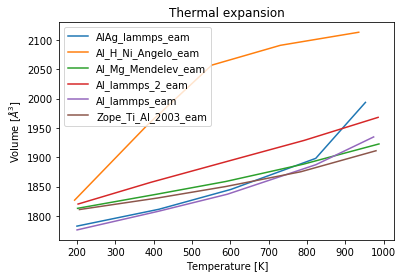

In [15]:
for p in pr.iter_groups():
    vol_lst, temp_lst = [], []
    for out in p.iter_jobs(path='output/generic'):
        volumes = out['volume']
        temperatures = out['temperatures']
        temp_lst.append(np.mean(temperatures[:-20]))
        vol_lst.append(np.mean(volumes[:-20]))
    plt.plot(temp_lst, vol_lst, label=p.name) 
plt.legend()    
plt.title('Thermal expansion')
plt.xlabel('Temperature [K]')
plt.ylabel('Volume [$\AA^3$]');